<a href="https://colab.research.google.com/github/aliicee3/LOGML2021-Learning-Latent-Geometries/blob/main/simplest_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import random
import numpy as np
import cv2
import base64
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from copy import deepcopy
from torch.autograd import Variable
from tqdm import tqdm
from pprint import pprint
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Training on',DEVICE)

Training on cuda


In [2]:

# !nvidia-smi

In [6]:
# !unzip /content/drive/MyDrive/datasets/archive.zip

In [10]:
DATASET_PATH ="/content/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/content/drive/MyDrive/datasets/lfw_attributes.txt"

In [11]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)
#too much Bush
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

,person,path
0,Bruce_Van_De_Velde,/content/lfw-deepfunneled/lfw-deepfunneled/Bru...
1,Bruce_Van_De_Velde,/content/lfw-deepfunneled/lfw-deepfunneled/Bru...
2,Iran_Brown,/content/lfw-deepfunneled/lfw-deepfunneled/Ira...
3,Katie_Holmes,/content/lfw-deepfunneled/lfw-deepfunneled/Kat...
4,McGuire_Gibson,/content/lfw-deepfunneled/lfw-deepfunneled/McG...
5,Patrick_Bourrat,/content/lfw-deepfunneled/lfw-deepfunneled/Pat...
6,Kyle_McLaren,/content/lfw-deepfunneled/lfw-deepfunneled/Kyl...
7,Chris_Klein,/content/lfw-deepfunneled/lfw-deepfunneled/Chr...
8,Zulfiqar_Ahmed,/content/lfw-deepfunneled/lfw-deepfunneled/Zul...
9,Robert_Kipkoech_Cheruiyot,/content/lfw-deepfunneled/lfw-deepfunneled/Rob...


In [12]:
def fetch_dataset(dx=80,dy=80, dimx=45,dimy=45):
    
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [13]:
data, attrs = fetch_dataset()

IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]

N_CHANNELS = 3

In [14]:
data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [15]:
X_train.shape

(10514, 45, 45, 3)

In [16]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

In [48]:
dim_z = 2

In [49]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(45*45*3, 1500)
        self.fc21 = nn.Linear(1500, dim_z)
        self.fc22 = nn.Linear(1500, dim_z)
        self.fc3 = nn.Linear(dim_z, 1500)
        self.fc4 = nn.Linear(1500, 45*45*3)        
        self.relu = nn.LeakyReLU()

    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        z = self.relu(self.fc3(z)) #1500
        return torch.sigmoid(self.fc4(z))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar
    
def loss_vae_fn(x, recon_x, mu, logvar):    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [50]:
model_vae = VAE().to(DEVICE)

In [51]:
def get_batch(data, batch_size=64):
    total_len = data.shape[0]
    for i in range(0, total_len, batch_size):
        yield data[i:min(i+batch_size,total_len)]

def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass
        

def fit_epoch_vae(model, train_x, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)        
        optimizer.zero_grad()
        
        decoded,mu,logvar, = model(inputs)
        outputs = decoded.view(-1, 45*45*3)
        outputs = outputs.to(DEVICE)
        
        loss = loss_vae_fn(inputs,outputs,mu,logvar)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch_vae(model, x_val, batch_size):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val,batch_size=batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            decoded,mu,logvar = model(inputs)
            outputs = decoded.view(-1, 45*45*3)        
            loss = loss_vae_fn(inputs,outputs,mu,logvar)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]         
        pic_input = pic.view(-1, 45*45*3)            
        pic_input = pic_input.to(DEVICE)        
        decoded,mu,logvar = model(inputs)        
        pic_output = decoded[0].view(-1, 45*45*3).squeeze()
        pic_output = pic_output.to("cpu") 
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train_vae(train_x, val_x, model, epochs=10, batch_size=32, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch_vae(model,train_x,optimizer,batch_size)
            val_loss = eval_epoch_vae(model,val_x,batch_size)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   2%|▏         | 1/50 [00:00<00:33,  1.46it/s]

loss:  549135.3402962716

Epoch 001 train_loss: 549135.3403 val_loss: 501856.2266


epoch:   4%|▍         | 2/50 [00:01<00:32,  1.47it/s]

loss:  502685.19649841875

Epoch 002 train_loss: 502685.1965 val_loss: 494029.8146


epoch:   6%|▌         | 3/50 [00:02<00:32,  1.47it/s]

loss:  497440.8554962431

Epoch 003 train_loss: 497440.8555 val_loss: 490028.8842


epoch:   8%|▊         | 4/50 [00:02<00:31,  1.47it/s]

loss:  496876.6450655079

Epoch 004 train_loss: 496876.6451 val_loss: 494760.2494


epoch:  10%|█         | 5/50 [00:03<00:30,  1.48it/s]

loss:  495198.7531654223

Epoch 005 train_loss: 495198.7532 val_loss: 488682.7437


epoch:  12%|█▏        | 6/50 [00:04<00:29,  1.48it/s]

loss:  495375.59400561155

Epoch 006 train_loss: 495375.5940 val_loss: 488327.5915


epoch:  14%|█▍        | 7/50 [00:04<00:29,  1.48it/s]

loss:  494098.0629101674

Epoch 007 train_loss: 494098.0629 val_loss: 493508.6573


epoch:  16%|█▌        | 8/50 [00:05<00:28,  1.48it/s]

loss:  496159.00489080034

Epoch 008 train_loss: 496159.0049 val_loss: 487838.1662


epoch:  18%|█▊        | 9/50 [00:06<00:27,  1.48it/s]

loss:  493155.35271572426

Epoch 009 train_loss: 493155.3527 val_loss: 495099.3028


epoch:  20%|██        | 10/50 [00:06<00:26,  1.49it/s]

loss:  493940.62839131156

Epoch 010 train_loss: 493940.6284 val_loss: 487659.2283


epoch:  22%|██▏       | 11/50 [00:07<00:26,  1.49it/s]

loss:  492345.6219831891

Epoch 011 train_loss: 492345.6220 val_loss: 487752.9756


epoch:  24%|██▍       | 12/50 [00:08<00:27,  1.36it/s]

loss:  492190.9180987849

Epoch 012 train_loss: 492190.9181 val_loss: 487120.5592


epoch:  26%|██▌       | 13/50 [00:08<00:26,  1.39it/s]

loss:  492065.9219389029

Epoch 013 train_loss: 492065.9219 val_loss: 492378.1361


epoch:  28%|██▊       | 14/50 [00:09<00:25,  1.42it/s]

loss:  494019.00847382064

Epoch 014 train_loss: 494019.0085 val_loss: 487077.5468


epoch:  30%|███       | 15/50 [00:10<00:24,  1.43it/s]

loss:  491876.47432144044

Epoch 015 train_loss: 491876.4743 val_loss: 486607.7761


epoch:  32%|███▏      | 16/50 [00:11<00:23,  1.44it/s]

loss:  491760.29371403606

Epoch 016 train_loss: 491760.2937 val_loss: 486826.2009


epoch:  34%|███▍      | 17/50 [00:11<00:22,  1.46it/s]

loss:  491742.3776289352

Epoch 017 train_loss: 491742.3776 val_loss: 486603.8104


epoch:  36%|███▌      | 18/50 [00:12<00:21,  1.47it/s]

loss:  492033.6502505588

Epoch 018 train_loss: 492033.6503 val_loss: 487105.7255


epoch:  38%|███▊      | 19/50 [00:13<00:21,  1.47it/s]

loss:  491710.9741208151

Epoch 019 train_loss: 491710.9741 val_loss: 486535.3368


epoch:  40%|████      | 20/50 [00:13<00:20,  1.48it/s]

loss:  491579.31606518687

Epoch 020 train_loss: 491579.3161 val_loss: 486599.8226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
epoch:  42%|████▏     | 21/50 [00:14<00:19,  1.48it/s]

loss:  491778.91989252425

Epoch 021 train_loss: 491778.9199 val_loss: 486782.8766


epoch:  44%|████▍     | 22/50 [00:15<00:18,  1.49it/s]

loss:  491592.01567404176

Epoch 022 train_loss: 491592.0157 val_loss: 486911.0432


epoch:  46%|████▌     | 23/50 [00:15<00:18,  1.49it/s]

loss:  492789.1278949496

Epoch 023 train_loss: 492789.1279 val_loss: 487261.4921


epoch:  48%|████▊     | 24/50 [00:16<00:17,  1.49it/s]

loss:  491606.65852078184

Epoch 024 train_loss: 491606.6585 val_loss: 486577.5288


epoch:  50%|█████     | 25/50 [00:17<00:16,  1.49it/s]

loss:  491532.1327916944

Epoch 025 train_loss: 491532.1328 val_loss: 486620.3980


epoch:  52%|█████▏    | 26/50 [00:17<00:16,  1.48it/s]

loss:  491495.5730291159

Epoch 026 train_loss: 491495.5730 val_loss: 486364.9805


epoch:  54%|█████▍    | 27/50 [00:18<00:15,  1.48it/s]

loss:  491476.41585029487

Epoch 027 train_loss: 491476.4159 val_loss: 486623.6487


epoch:  56%|█████▌    | 28/50 [00:19<00:14,  1.48it/s]

loss:  491464.3444321262

Epoch 028 train_loss: 491464.3444 val_loss: 486574.2155


epoch:  58%|█████▊    | 29/50 [00:19<00:14,  1.48it/s]

loss:  491495.5257588097

Epoch 029 train_loss: 491495.5258 val_loss: 486599.7066


epoch:  60%|██████    | 30/50 [00:20<00:13,  1.49it/s]

loss:  491436.74344326614

Epoch 030 train_loss: 491436.7434 val_loss: 486592.0556


epoch:  62%|██████▏   | 31/50 [00:21<00:12,  1.49it/s]

loss:  491426.34602078184

Epoch 031 train_loss: 491426.3460 val_loss: 486411.9166


epoch:  64%|██████▍   | 32/50 [00:21<00:12,  1.49it/s]

loss:  491437.72025840543

Epoch 032 train_loss: 491437.7203 val_loss: 486871.3151


epoch:  66%|██████▌   | 33/50 [00:22<00:11,  1.49it/s]

loss:  491507.2921640194

Epoch 033 train_loss: 491507.2922 val_loss: 486452.7967


epoch:  68%|██████▊   | 34/50 [00:23<00:10,  1.48it/s]

loss:  491450.2145710481

Epoch 034 train_loss: 491450.2146 val_loss: 487110.1960


epoch:  70%|███████   | 35/50 [00:23<00:10,  1.49it/s]

loss:  491444.7597994341

Epoch 035 train_loss: 491444.7598 val_loss: 486394.0769


epoch:  72%|███████▏  | 36/50 [00:24<00:09,  1.49it/s]

loss:  491431.2272312512

Epoch 036 train_loss: 491431.2272 val_loss: 486773.4025


epoch:  74%|███████▍  | 37/50 [00:25<00:08,  1.49it/s]

loss:  491427.75938332226

Epoch 037 train_loss: 491427.7594 val_loss: 486395.7879


epoch:  76%|███████▌  | 38/50 [00:25<00:08,  1.48it/s]

loss:  491514.7646545677

Epoch 038 train_loss: 491514.7647 val_loss: 486451.9981


epoch:  78%|███████▊  | 39/50 [00:26<00:07,  1.42it/s]

loss:  491439.76819003234

Epoch 039 train_loss: 491439.7682 val_loss: 486423.3001


epoch:  80%|████████  | 40/50 [00:27<00:06,  1.43it/s]

loss:  491392.84501914115

Epoch 040 train_loss: 491392.8450 val_loss: 486649.5906


epoch:  82%|████████▏ | 41/50 [00:27<00:06,  1.45it/s]

loss:  491382.6230680521

Epoch 041 train_loss: 491382.6231 val_loss: 486789.3868


epoch:  84%|████████▍ | 42/50 [00:28<00:05,  1.46it/s]

loss:  491386.81330250145

Epoch 042 train_loss: 491386.8133 val_loss: 487133.9978


epoch:  86%|████████▌ | 43/50 [00:29<00:04,  1.47it/s]

loss:  491604.87897238205

Epoch 043 train_loss: 491604.8790 val_loss: 491305.8144


epoch:  88%|████████▊ | 44/50 [00:29<00:04,  1.46it/s]

loss:  493050.6892714476

Epoch 044 train_loss: 493050.6893 val_loss: 486853.5713


epoch:  90%|█████████ | 45/50 [00:30<00:03,  1.47it/s]

loss:  491445.7051476008

Epoch 045 train_loss: 491445.7051 val_loss: 487139.0967


epoch:  92%|█████████▏| 46/50 [00:31<00:02,  1.46it/s]

loss:  491433.4753424006

Epoch 046 train_loss: 491433.4753 val_loss: 486399.1991


epoch:  94%|█████████▍| 47/50 [00:32<00:02,  1.47it/s]

loss:  491342.16354681854

Epoch 047 train_loss: 491342.1635 val_loss: 486989.1100


epoch:  96%|█████████▌| 48/50 [00:32<00:01,  1.47it/s]

loss:  491444.12664810015

Epoch 048 train_loss: 491444.1266 val_loss: 486645.0706


epoch:  98%|█████████▊| 49/50 [00:33<00:00,  1.47it/s]

loss:  491324.2781737445

Epoch 049 train_loss: 491324.2782 val_loss: 486370.3261


epoch: 100%|██████████| 50/50 [00:34<00:00,  1.47it/s]

loss:  491325.9857422247

Epoch 050 train_loss: 491325.9857 val_loss: 486370.9783


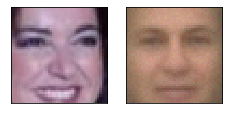

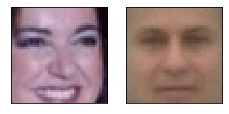

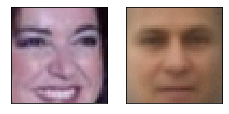

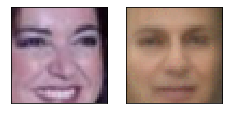

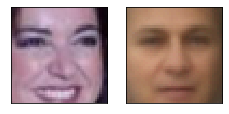

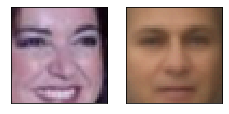

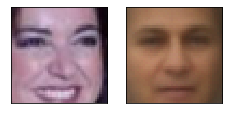

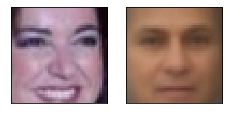

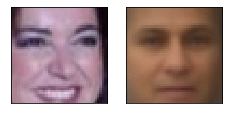

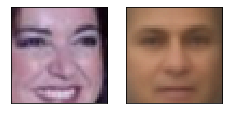

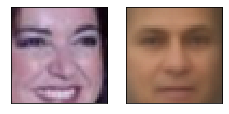

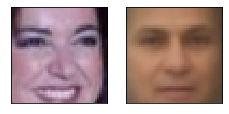

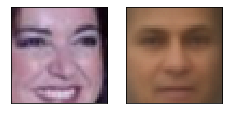

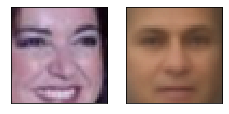

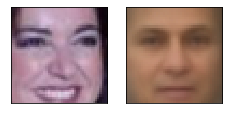

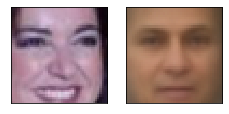

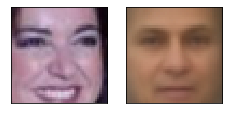

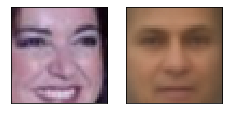

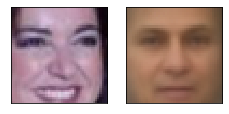

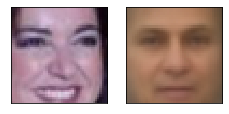

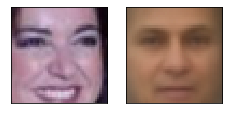

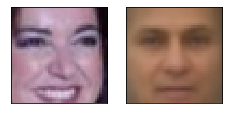

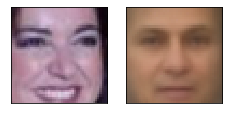

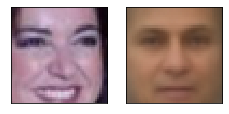

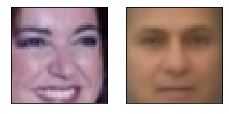

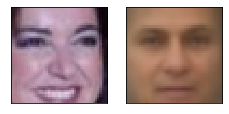

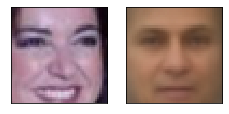

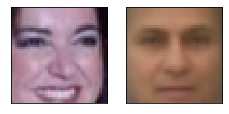

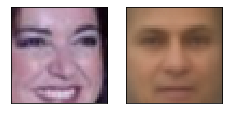

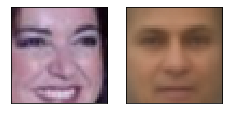

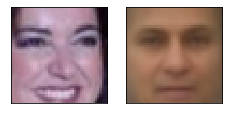

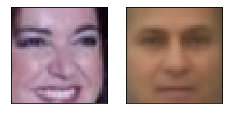

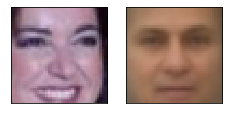

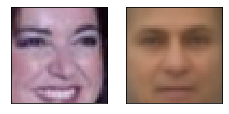

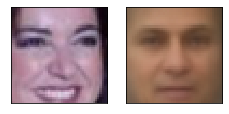

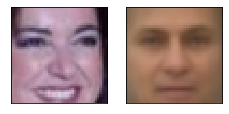

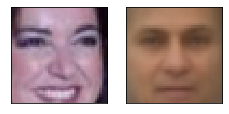

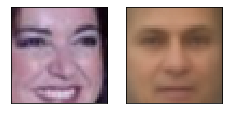

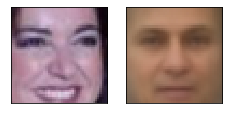

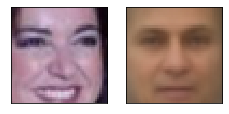

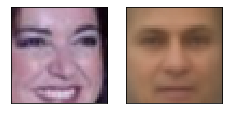

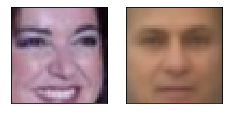

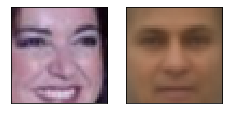

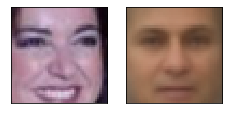

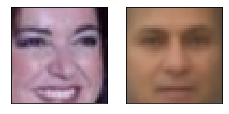

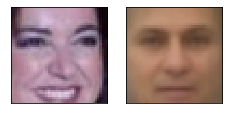

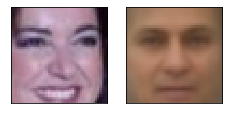

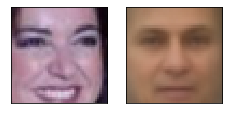

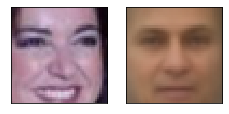

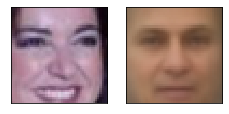

In [52]:
history_vae = train_vae(X_train, X_val, model_vae, epochs=50, batch_size=128, lr=0.001)

(50, 2)


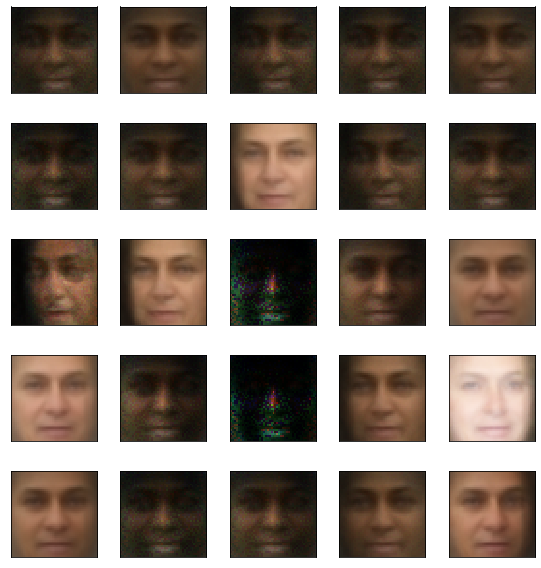

In [53]:
z = np.random.randn(50, dim_z)
print(z.shape)

with torch.no_grad():
    inputs = torch.FloatTensor(z)    
    inputs = inputs.to(DEVICE)
    model_vae.eval()
    output = model_vae.decode(inputs)
    plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)
        

In [38]:
dim_z

32